<a href="https://colab.research.google.com/github/sumanyumuku98/Generative-Adversarial-Networks-Keras/blob/master/DCGAN__Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from keras.layers import Dense,Dropout,Input, Reshape
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize'] = [4.0,4.0]
import warnings
warnings.filterwarnings('ignore')
import keras.backend as K
import tensorflow as tf
from sklearn.utils import shuffle
from keras.datasets import cifar10
import cv2
from collections import defaultdict
import glob
from skimage.transform import resize
import h5py
from keras.layers import BatchNormalization
#import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks")
plt.rcParams['axes.grid'] = False

In [3]:
os.listdir()

['Untitled0.ipynb',
 'Untitled1.ipynb',
 'Copy of Hello, Colaboratory',
 'Untitled2.ipynb',
 'Untitled3.ipynb',
 'Untitled4.ipynb',
 'Untitled5.ipynb',
 'GANS---Ian Goodfellow.ipynb',
 'Action_Recognition_Pytorch.ipynb',
 'weights_dcgan',
 'lsun.h5',
 'DCGAN__Keras.ipynb']

In [0]:
WEIGHTS_PATH = "/content/drive/My Drive/Colab Notebooks/weights_dcgan/"

In [5]:
"""image_data = []
files = glob.glob("/Users/sumanyu/Desktop/RL/data0/lsun/bedroom/*/**/*.jpg",recursive =True)
counter = 0
for file in files:
    image = cv2.imread(file)
    res_image = resize(image,(64,64),anti_aliasing= True)
    image_data.append(res_image)
    counter+=1
    if counter %10000==0:
      image_data_np = np.array(image_data)
      print(image_data_np.shape)
      with h5py.File('lsun.h5','w') as hf:
         hf.create_dataset('lsun_dataset',data = image_data_np)
      break
"""
# Got the unprocessed lsun dataset from this link : https://www.kaggle.com/jhoward/lsun_bedroom/data
# Above snippet of code resizes the image to (64,64) and anti- aliases it and finally stores
# it as an .h5 file
# The dataset contains 300k images and i am using about 10k

'image_data = []\nfiles = glob.glob("/Users/sumanyu/Desktop/RL/data0/lsun/bedroom/*/**/*.jpg",recursive =True)\ncounter = 0\nfor file in files:\n    image = cv2.imread(file)\n    res_image = resize(image,(64,64),anti_aliasing= True)\n    image_data.append(res_image)\n    counter+=1\n    if counter %10000==0:\n      image_data_np = np.array(image_data)\n      print(image_data_np.shape)\n      with h5py.File(\'lsun.h5\',\'w\') as hf:\n         hf.create_dataset(\'lsun_dataset\',data = image_data_np)\n      break\n'

In [0]:
with h5py.File('/content/drive/My Drive/Colab Notebooks/lsun.h5','r') as hf:
  images_train = hf['lsun'][:]

In [7]:
print(images_train.shape)

(10000, 64, 64, 3)


In [0]:
batch_size = 128
def image_loader(x_train,batch_size=128):
    length = x_train.shape[0]
    start = 0
    end = batch_size
    while start < length:
        limit = min(end,length)
        yield x_train[start:end]
        start+=batch_size
        end+=batch_size

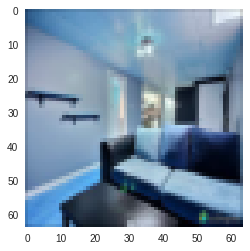

In [9]:
data_iter = image_loader(images_train,batch_size=128) #Visualizing the data
images  = next(data_iter)
plt.imshow(images[0])

In [10]:


import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))




Found GPU at: /device:GPU:0


In [0]:
class DCGAN():
    def __init__(self,latent_size,image_dim,feature_maps,X_train,labels_train= None,epochs = 200):
        self.latent_size = latent_size
        self.image_dim = image_dim
        self.X_train = X_train
        self.labels_train = labels_train
        self.feature_maps = feature_maps
        self.epochs = epochs
        
    def build_generator(self):
        model = Sequential()
        #(100,)----> (batch_size,512,4,4)
        model.add(Dense(512*4*4,kernel_initializer= keras.initializers.RandomNormal(mean = 0.0, stddev=0.02),input_shape = (self.latent_size,)))
        model.add(Reshape((4,4,512)))
        model.add(BatchNormalization())
        model.add(ReLU())
        # (512,4,4)----> (256,8,8)          
        model.add(keras.layers.Conv2DTranspose(self.feature_maps*4,kernel_size=4,strides=2, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        model.add(BatchNormalization())
        model.add(ReLU())
        #(256,8,8)--->(128,16,16)
        model.add(keras.layers.Conv2DTranspose(self.feature_maps*2,kernel_size=4,strides=2, padding='same',kernel_initializer=keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        model.add(BatchNormalization())
        model.add(ReLU())
        #(128,16,16)---> (64,32,32) 
        model.add(keras.layers.Conv2DTranspose(self.feature_maps,kernel_size=4,strides=2,   padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        model.add(BatchNormalization())
        model.add(ReLU())
        #(64,32,32)---->(3,64,64)
        model.add(keras.layers.Conv2DTranspose(3,kernel_size=4,strides=2, padding='same',activation='tanh',kernel_initializer=keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        
        latent_vector = Input(shape = (self.latent_size,))
        gen_image = model(latent_vector)
        #print(gen_image.shape)
        return Model(latent_vector,gen_image)
    
    def build_discriminator(self):
        model = Sequential()
        # (3,64,64)--->(64,32,32)
        model.add(keras.layers.Conv2D(self.feature_maps,kernel_size=4,strides = 2,padding='same',kernel_initializer= keras.initializers.RandomNormal(mean=0.0,stddev=0.02),input_shape = (self.image_dim,self.image_dim,3)))
        model.add(LeakyReLU(0.2))
        # (64,32,32)----> (128,16,16)
        model.add(keras.layers.Conv2D(self.feature_maps*2,kernel_size=4,strides = 2,padding='same',kernel_initializer= keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #(128,16,16)--->((256,8,8))
        model.add(keras.layers.Conv2D(self.feature_maps*4,kernel_size=4,strides = 2,padding='same',kernel_initializer= keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        
        #(256,8,8)--->(512,4,4)
        model.add(keras.layers.Conv2D(self.feature_maps*8,kernel_size=4,strides = 2,padding='same',kernel_initializer= keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #(512,4,4)-->scalar value(1*1)
        model.add(keras.layers.Conv2D(1,kernel_size=4,strides = 1,padding='valid',activation = 'sigmoid',kernel_initializer= keras.initializers.RandomNormal(mean=0.0,stddev=0.02)))
        model.add(Reshape((1*1*1,)))
        
        
        image = Input(shape=(self.image_dim,self.image_dim,3))
        prob = model(image)
        #for i in range(3)[:-1]:
         # prob = K.squeeze(prob,axis = i+1)
       
        return Model(image,prob)
        
    def train(self):
        self.batch_size = 128
        # no. of test samples for checking the quality of images produced by generator
        self.sample_size = 16
        # for storing generator and discriminator loss per epoch
        self.train_history = defaultdict(list)
        
        self.fixed_z = np.random.uniform(-1,1,(self.sample_size,self.latent_size))
        self.samples = []
        discriminator = self.build_discriminator()
        generator = self.build_generator()
        noise = Input(shape=(self.latent_size,))
        fake_img = generator(noise)
        # using adam optimizer with hyperparameters as mentioned in the paper and bce for fake or real images.
        discriminator.compile(optimizer=Adam(lr=2e-4, beta_1=0.5),loss = keras.losses.binary_crossentropy,metrics = ['acc'])
        discriminator.summary()
        
        discriminator.trainable = False
        fake = discriminator(fake_img)
        combined = Model(noise,fake)
        # Training the generator as a stack of generator and discriminator but the weights of discriminator are frozen here
        combined.compile(optimizer = Adam(lr = 2e-4,beta_1=0.5),loss = keras.losses.binary_crossentropy,metrics=['acc'])
        combined.summary()
        
        for epochs in range(self.epochs):
            epoch_gen_loss = []
            epoch_dis_loss = []
            
            num_batches = int(np.ceil(self.X_train.shape[0] / float(self.batch_size)))
            # progres bar for visualisation mainly
            progbar = Progbar(target=num_batches)
            
            for batch_i,real_images in enumerate(image_loader(self.X_train,self.batch_size)):
                
                batch_size = real_images.shape[0]
                real_images = real_images*2 -1
               # real_images = np.rollaxis(real_images,3,1)
                # Assiging label 1 to real images for training discriminator
                real_labels = np.ones(shape=(batch_size,),dtype=int)
                random_noise = np.random.uniform(-1,1,size=(batch_size,self.latent_size))
                # Assigning label 0 for fake images by generator to train discriminator
                fake_images = generator.predict(random_noise)
                fake_labels = np.zeros(shape=(batch_size,),dtype=np.int)
                
                final_images = np.concatenate((real_images,fake_images),axis=0)
                final_labels = np.concatenate((real_labels,fake_labels),axis = 0)

                
                final_images,final_labels = shuffle(final_images,final_labels)
                epoch_dis_loss.append(discriminator.train_on_batch(final_images,final_labels))
                
                
                new_noise = np.random.uniform(-1,1,size=(2*batch_size,self.latent_size))
                new_fake_labels = np.ones(shape=(2*batch_size,), dtype=int)
                # Assigning label 1 to new fake images for training generator in order to fool the 
                # discriminator to think that they are real.
                epoch_gen_loss.append(combined.train_on_batch(new_noise,new_fake_labels))
                progbar.update(batch_i+1)
                
            
            discriminator_train_loss = np.mean(np.array(epoch_dis_loss), axis=0)
            generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
            self.train_history['generator'].append(generator_train_loss)
            self.train_history['discriminator'].append(discriminator_train_loss)
            print('At Epoch:{}-->Generator_loss:{} and Discriminator_loss:{}'.format(epochs+1,generator_train_loss[0],discriminator_train_loss[0]))

            print("Testing for epoch:{}".format(epochs+1))
            
            test_sample = generator.predict(self.fixed_z,steps = 1)
            self.samples.append(test_sample)
            print('Samples generated')
            
                
            if (epochs+1)%5==0:
                generator.save(WEIGHTS_PATH+"generator_epoch:{}.h5".format(epochs+1))
                discriminator.save(WEIGHTS_PATH+"discriminator_epoch:{}.h5".format(epochs+1))
           
        return (self.samples,self.train_history)
    
        
    
    

In [0]:
lsun_dcgan_obj = DCGAN(100,64,64,images_train,epochs=100) 

In [0]:
generator = lsun_dcgan_obj.build_generator()
z = np.random.uniform(-1,1,size=(2,100))

fake_img = generator.predict(z)
print(fake_img.shape)
discriminator = lsun_dcgan_obj.build_discriminator()
prob = discriminator.predict(fake_img)
print(prob)

(2, 64, 64, 3)
[[0.5000097 ]
 [0.50000125]]


In [0]:
prob.shape

(2, 1)

In [13]:
lsun_dcgan_obj.train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 2768321   
Total params: 2,768,321
Trainable params: 2,766,529
Non-trainable params: 1,792
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 3)         3587267   
_________________________________________________________________
model_1 (Model)              (None, 1)                 2768321   
Total params: 6,355,588
Trainable params: 3,585,347
Non-traina

([array([[[[ 3.80518138e-02,  1.00274468e-02,  4.16498892e-02],
           [-3.98707092e-02, -2.45707165e-02, -3.72623503e-02],
           [-6.20100461e-03, -6.35110214e-02,  6.88786209e-02],
           ...,
           [-8.31346735e-02,  7.21577033e-02, -1.36313498e-01],
           [ 7.36649260e-02, -6.25291541e-02,  2.61778682e-02],
           [-6.00082166e-02, -3.08800079e-02, -5.97457513e-02]],
  
          [[ 2.19579227e-02,  8.65010396e-02,  2.77913678e-02],
           [-4.98624109e-02, -2.13275209e-01, -6.28900900e-02],
           [ 4.55318056e-02,  1.11859709e-01,  1.44279182e-01],
           ...,
           [ 3.31459083e-02,  8.41431599e-03, -2.47374177e-02],
           [ 6.17977828e-02,  8.69472027e-02, -6.50650030e-03],
           [ 6.06556833e-02, -9.94163752e-02,  7.43222982e-02]],
  
          [[ 9.71663073e-02, -8.57553035e-02, -3.33719589e-02],
           [-8.22985843e-02, -1.10428587e-01,  1.64218143e-01],
           [ 8.56772959e-02, -3.11298043e-01,  1.28644124e-01],


In [0]:
samples = lsun_dcgan_obj.samples
train_history  = lsun_dcgan_obj.train_history
gen_loss,gen_acc = zip(*train_history['generator'])
dis_loss,dis_acc = zip(*train_history['discriminator'])


In [22]:
dis_loss_ls = list(dis_loss)
gen_loss_ls = list(gen_loss)
print(len(gen_loss_ls),len(dis_loss_ls))


100 100


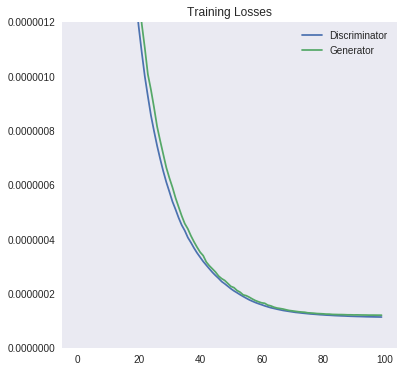

In [39]:
fig, ax = plt.subplots(figsize = (6.0,6.0))
plt.plot(dis_loss_ls, label='Discriminator')
plt.plot(gen_loss_ls, label='Generator')
ax.set_ylim([0.0,12e-7])
plt.title("Training Losses")
plt.legend()

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch-1]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow((img+1.0)/2.0, cmap='Greys_r')


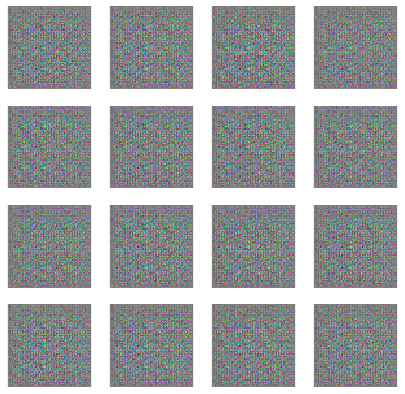

In [54]:
# Some pattern can be observed but it is mostly noise because of low amount of data used in training
view_samples(100,samples)